source: https://www.kaggle.com/code/robikscube/train-your-first-pytorch-model-card-classifier#Bonus:-Evaluating-the-Results

In [1]:
# Pytorch
import torch
from torch import nn
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import Dataset, DataLoader

# Torchvision: make working with image files easier
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# progress bar
from tqdm import tqdm 

# optimizer
import torch.optim as optim

In [3]:
class SyntheticDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform) 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes # returns dataset classes from ImageFolder

In [2]:
class SyntheticDataClassifier(nn.Module):
    def __init__(self, num_classes=2, weights='DEFAULT'):
        super(SyntheticDataClassifier, self).__init__()
        self.model = resnet18(weights=weights)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)  # Modify the last fully connected layer
    
    def forward(self, x):
        return self.model(x)

In [5]:
# Define the transformation operation that suits resnet18
weights = ResNet18_Weights.DEFAULT
transform_operation = weights.transforms() 

# Create a dataset object
train_data = SyntheticDataset(data_dir='dataset\\train', transform=transform_operation)
test_data = SyntheticDataset(data_dir='dataset\\test', transform=transform_operation)

# Create a DataLoader object for training - faster training in batches
train_loader = DataLoader(train_data, batch_size=32, shuffle=True) 
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [6]:
# Training the model
num_epochs = 5
train_losses = []
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
model = SyntheticDataClassifier(num_classes=2, weights=weights).to(device)    
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc='Training loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * labels.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}")

Training loop: 100%|██████████| 21/21 [00:52<00:00,  2.50s/it]


Epoch 1/5, Training Loss: 0.2843065063158671


Training loop: 100%|██████████| 21/21 [00:51<00:00,  2.47s/it]


Epoch 2/5, Training Loss: 0.14273440789698255


Training loop: 100%|██████████| 21/21 [00:50<00:00,  2.40s/it]


Epoch 3/5, Training Loss: 0.08761986533058023


Training loop: 100%|██████████| 21/21 [00:53<00:00,  2.57s/it]


Epoch 4/5, Training Loss: 0.17560050711021222


Training loop: 100%|██████████| 21/21 [00:52<00:00,  2.51s/it]

Epoch 5/5, Training Loss: 0.05962596648166716


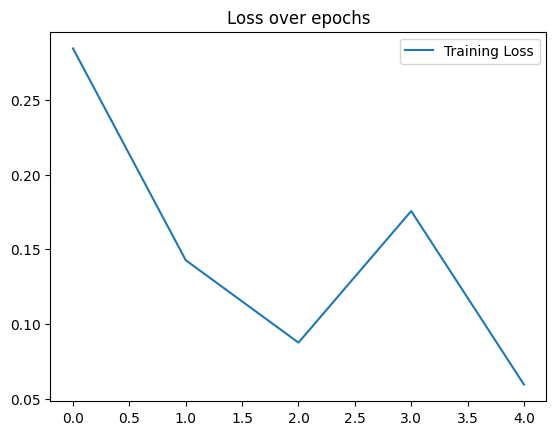

In [8]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

In [9]:
# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

In [10]:
# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

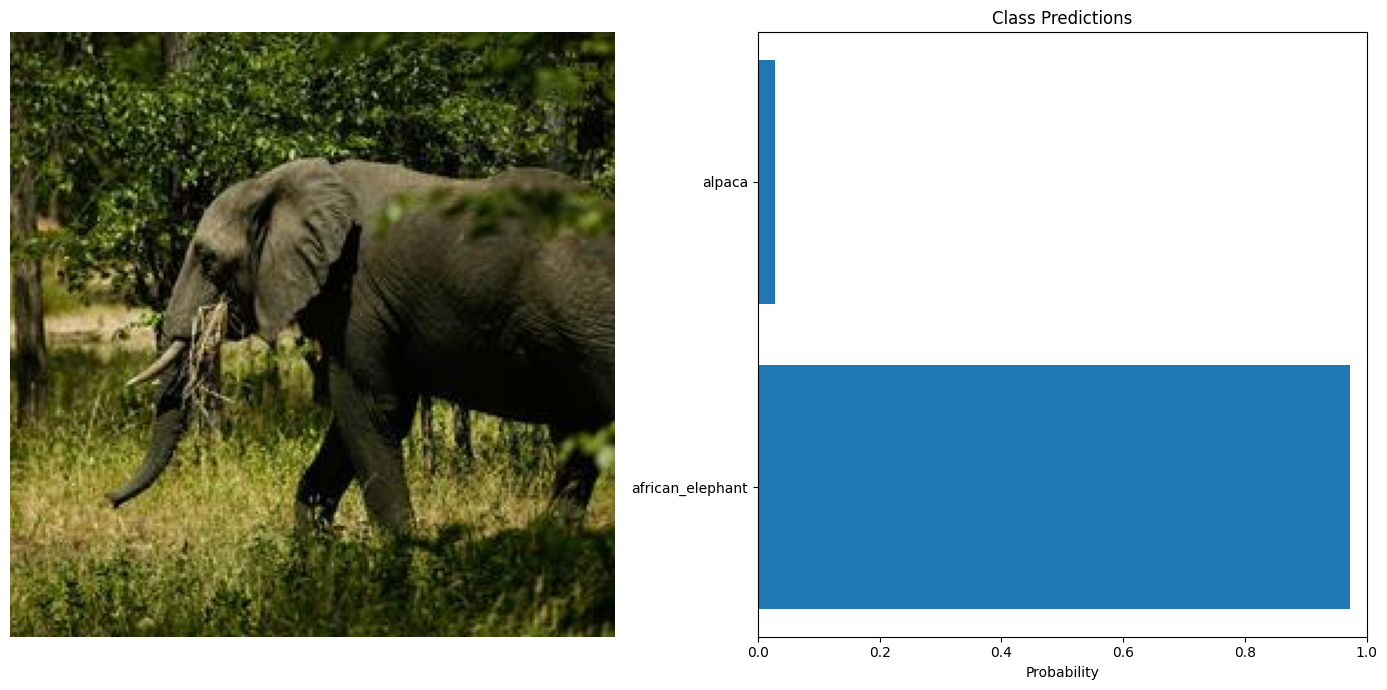

In [19]:
from PIL import Image
# Example usage
test_image = "dataset\\test\\african_elephant\\african_elephant-0325.jpg"
original_image, image_tensor = preprocess_image(test_image, transform_operation) # determined earlier in the code
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = train_data.classes 
visualize_predictions(original_image, probabilities, class_names)